<h1> The Importance of Personality Traits in Agile Software Development: A Case Study </h1>
<hr/>

<h2> 1.0 Developers` personality insight analysis <hr />
using the open source datasets of eoght software development teams JIRA logs </h2>

<h3>1.0.1 load libraries and datasets</h3>

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Rectangle
import seaborn as sns
import re
from collections import Counter
import pandasql as ps
from apyori import apriori

In [2]:
changelog = pd.read_csv('original_data/jiradataset_changelog.csv')
issues = pd.read_csv('original_data/jiradataset_issues.csv')
sprints = pd.read_csv('original_data/jiradataset_sprints.csv')
users = pd.read_csv('original_data/jiradataset_users.csv')

<h3> Read IBM Watson personality traits results data </h3>



In [42]:
user_personalities=pd.read_csv('input_data/user_personalities.csv')
pd.set_option('display.float_format', lambda x: '%.3f' % x)

<h2> Calculation of metrics </h2>

<h3> Time </h3>

First, let's define the time spent per task by the developer: time that is passed while the task was set to 'In Progress' status.
In technical terms, this is the time between the two log records when 1) the task status was set to 'In Progress'
and 2)task status was changed from 'In Progress'. 


Get the records from Jira change log, that have status set from In Progress to something else, and the records that have set status set to In Progress from something else.

In [9]:
changelog_from_inprogress = changelog[(changelog['field']=='status') 
                                    & (changelog['fromString']=='In Progress')
                                    & (changelog['toString']!='In Progress')].reset_index()
changelog_to_inprogress = changelog[(changelog['field']=='status') 
                                    & (changelog['toString']=='In Progress') 
                                    & (changelog['fromString']!='In Progress')].reset_index()
changelog_to_inprogress.head()

,index,author,created,field,fieldtype,from,fromString,key,project,to,toString
0,0,jvalkeal,2016-03-03 18:40:53.171,status,jira,10000,To Do,XD-3751,xd,3,In Progress
1,12,grussell,2016-02-29 19:43:42.553,status,jira,10000,To Do,XD-3748,xd,3,In Progress
2,19,mark.pollack,2016-02-23 18:18:59.225,status,jira,10000,To Do,XD-3746,xd,3,In Progress
3,25,mark.pollack,2016-02-23 18:04:22.616,status,jira,10000,To Do,XD-3745,xd,3,In Progress
4,37,grussell,2016-02-22 15:49:30.944,status,jira,10000,To Do,XD-3744,xd,3,In Progress


let's join these two datasets, and have one row for each from-to in progress status record.
Technically: loop through each record where task status was changed form 'In Progress' to some other status (this record indicates that developer has stopped working on it). For each of these records, find the one latest record, where task status was set to 'In Progress' (this record indicates that developer has started working on it). With this operation we will get starting and ending time of work on the task by developer, and we will just need to calculate time difference.
<hr> In case when several developers have worked on one task - the function will calculate time for each of them separately.
<br> In case when one developer has set status to 'In Progress' multiple times within one task, the function will calculate the sum amount, so that one developer will have one number of minutes spent for one task. 

In [10]:
changelog_from_inprogress['prev_status'] = np.nan
changelog_from_inprogress['prev_status_created'] = np.nan
changelog_from_inprogress['created'] = pd.to_datetime(changelog_from_inprogress['created'])
changelog_to_inprogress['created'] = pd.to_datetime(changelog_to_inprogress['created'])

for index, row in changelog_from_inprogress.iterrows():
    _key = row['key']
    _project = row['project']
    _created = row['created']
    _to_row = changelog_to_inprogress[(((changelog_to_inprogress['key'] == _key)
                            & (changelog_to_inprogress['project'] == _project))
                            & (pd.to_datetime(changelog_to_inprogress['created']) < pd.to_datetime(_created)))].sort_values('created', ascending=False).head(1)
    for st in _to_row['fromString']:
        _prev_st = st 
    for cr in _to_row['created']:
        _prev_st_created = cr 
    
    changelog_from_inprogress.loc[index,'prev_status'] = _prev_st
    changelog_from_inprogress.loc[index,'prev_status_created'] = _prev_st_created

Calcualte minutes spent on each task

In [11]:
changelog_from_inprogress['minutes_spent']=(pd.to_datetime(changelog_from_inprogress['created'])
                            - pd.to_datetime(changelog_from_inprogress['prev_status_created'])) / np.timedelta64(1, 'm')
changelog_from_inprogress.head(3)

,index,author,created,field,fieldtype,from,fromString,key,project,to,toString,prev_status,prev_status_created,minutes_spent
0,2,jvalkeal,2016-03-03 18:41:19.429,status,jira,3,In Progress,XD-3751,xd,10006,In PR,To Do,2016-03-03 18:40:53.171000,0.438
1,14,grussell,2016-02-29 21:11:29.703,status,jira,3,In Progress,XD-3748,xd,10006,In PR,To Do,2016-02-29 19:43:42.553000,87.786
2,20,mark.pollack,2016-02-23 18:19:04.071,status,jira,3,In Progress,XD-3746,xd,10006,In PR,To Do,2016-02-23 18:18:59.225000,0.081


Sum up the time by the same users for the same tasks

In [12]:
user_key_timespent=changelog_from_inprogress.groupby(['key', 'project', 'author']).agg({'minutes_spent':'sum'})
user_key_timespent.reset_index(level= [0,1,2], inplace=True)

In [13]:
user_key_timespent.head(3)

,key,project,author,minutes_spent
0,APSTUD-1378,apstud,cwilliams,340.033
1,APSTUD-1469,apstud,mstepanov,121.633
2,APSTUD-1469,apstud,sgibly,54.717


In [14]:
user_key_timespent = user_key_timespent[user_key_timespent['minutes_spent']>0]

Let's join the time spendings dataset with the users dataset, that are valid for personality traits check.

In [15]:
valid_users_times = pd.merge(user_personalities, user_key_timespent, how = 'inner',
        left_on = 'user', right_on = 'author')[['user', 'project', 'key', 'minutes_spent']]

In [16]:
valid_users_times.head()

,user,project,key,minutes_spent
0,grussell,xd,XD-1127,0.578
1,grussell,xd,XD-1153,1452.161
2,grussell,xd,XD-1164,73.852
3,grussell,xd,XD-128,1688.373
4,grussell,xd,XD-1338,20246.750


In [17]:
print(user_personalities.shape[0], valid_users_times.shape[0])

100 8093


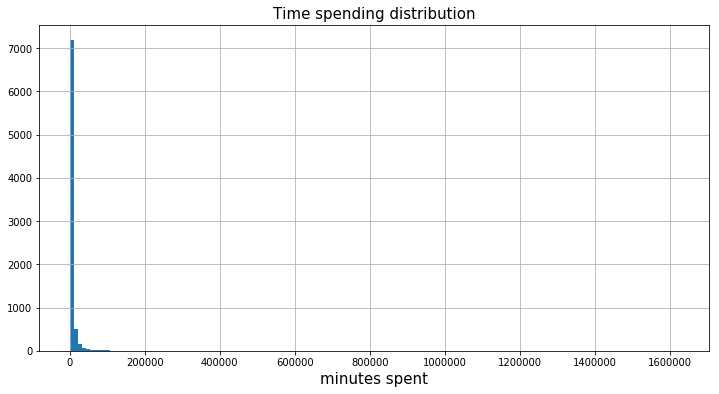

In [18]:
fig = plt.figure(figsize=(12, 6))
valid_users_times['minutes_spent'].hist(bins=150)
plt.title('Time spending distribution', fontsize=15)
plt.xlabel('minutes spent', fontsize=15)
plt.savefig('picture_output/time_1.jpg')

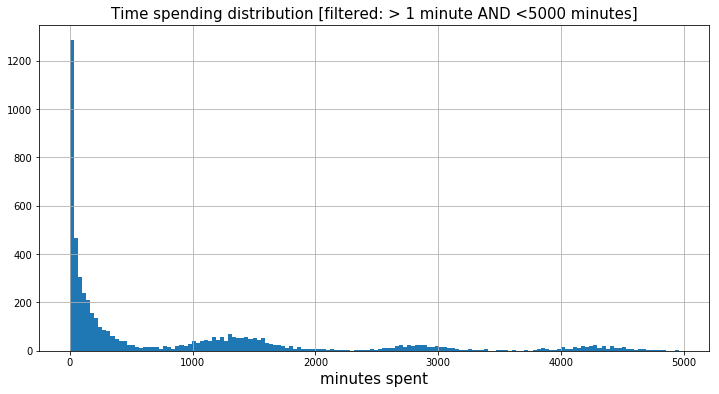

In [19]:
fig = plt.figure(figsize=(12, 6))
valid_users_times[(valid_users_times['minutes_spent']<5000) & (valid_users_times['minutes_spent']>1)]['minutes_spent'].hist(bins=150)
plt.title('Time spending distribution [filtered: > 1 minute AND <5000 minutes]', fontsize=15)
plt.xlabel('minutes spent', fontsize=15)
plt.savefig('picture_output/time_2.jpg')

Based on the times spent by the developers, let's define the high, normal and low time spend categories.
First, let's find the values where to split the rows: first < 33.33% time spend - low time spending, from 33.33% to 66.66% medium time spent, and from 66.66% and more - high time spending.

In [20]:
_top_percentile=0.3109
_bottom_percentile=0.5139
_rownumber_within_top_percentile = round((int(valid_users_times.shape[0]) * _top_percentile))
_rownumber_within_bottom_percentile = round((int(valid_users_times.shape[0]) * _bottom_percentile))
_top_percentile_rows_filter_value_minutes = valid_users_times.sort_values('minutes_spent', ascending=False).head(_rownumber_within_top_percentile).iloc[_rownumber_within_top_percentile-1].minutes_spent
_bottom_percentile_rows_filter_value_minutes = valid_users_times.sort_values('minutes_spent', ascending=True).head(_rownumber_within_bottom_percentile).iloc[_rownumber_within_bottom_percentile-1].minutes_spent

print(_rownumber_within_top_percentile, _rownumber_within_bottom_percentile, _top_percentile_rows_filter_value_minutes, _bottom_percentile_rows_filter_value_minutes)
print('nr of rows from ', _bottom_percentile*100, '% to ',
      str(100-100*_top_percentile), '% : ',
      valid_users_times[(valid_users_times['minutes_spent']<_top_percentile_rows_filter_value_minutes) & 
                        ( valid_users_times['minutes_spent']>_bottom_percentile_rows_filter_value_minutes)].shape[0])

print('nr of rows above ', str(100-100*_top_percentile), '%: ',
      valid_users_times[valid_users_times['minutes_spent']>=_top_percentile_rows_filter_value_minutes].shape[0])

print('nr of rows below, ', _bottom_percentile*100, '%: ',
      valid_users_times[valid_users_times['minutes_spent']<=_bottom_percentile_rows_filter_value_minutes].shape[0])

print('Total number of rows in dataset: ', valid_users_times.shape[0])

2516 4159 2400.3375833333334 480.6338333333333
nr of rows from  51.39 % to  68.91 % :  1418
nr of rows above  68.91 %:  2516
nr of rows below,  51.39 %:  4159
Total number of rows in dataset:  8093


In [21]:
valid_users_times['time_spending_category'] = np.nan

valid_users_times.loc[(valid_users_times['minutes_spent']<_top_percentile_rows_filter_value_minutes) & 
                        ( valid_users_times['minutes_spent']>_bottom_percentile_rows_filter_value_minutes)
                  , 'time_spending_category'] = 'time_medium'

valid_users_times.loc[valid_users_times['minutes_spent']>=_top_percentile_rows_filter_value_minutes
                      , 'time_spending_category']='time_high'

valid_users_times.loc[valid_users_times['minutes_spent']<=_bottom_percentile_rows_filter_value_minutes
                      , 'time_spending_category']='time_low'
# check the actual values
valid_users_times[['time_spending_category', 'user']].groupby('time_spending_category').count()

,user
time_spending_category,
time_high,2516
time_low,4159
time_medium,1418


In [22]:
valid_users_times.head()

,user,project,key,minutes_spent,time_spending_category
0,grussell,xd,XD-1127,0.578,time_low
1,grussell,xd,XD-1153,1452.161,time_medium
2,grussell,xd,XD-1164,73.852,time_low
3,grussell,xd,XD-128,1688.373,time_medium
4,grussell,xd,XD-1338,20246.750,time_high


Now, let's group the data the following way: to have one record for each user, and columns will be number of tasks where the user had low, medium and high time spendings.

In [23]:
q1 = """
Select U.user, low_timespent_tasks, medium_timespent_tasks, high_timespent_tasks
From 
    (
    Select distinct user From valid_users_times) AS U
    Left Join ( SELECT user, count(*) AS low_timespent_tasks
    FROM valid_users_times AS F WHERE time_spending_category = 'time_low' Group By user
    ) AS Low ON U.user = Low.user
    Left Join (SELECT user, count(*) AS medium_timespent_tasks
    FROM valid_users_times AS F WHERE time_spending_category = 'time_medium' Group By user
    ) AS medium on U.user = medium.user
    Left Join ( SELECT user, count(*) AS high_timespent_tasks
    FROM valid_users_times AS F WHERE time_spending_category = 'time_high' Group By user
    ) AS high ON U.user = high.user
"""

valid_user_time_agg = ps.sqldf(q1, locals())
print(valid_user_time_agg.shape[0])
valid_user_time_agg.head()

80


,user,low_timespent_tasks,medium_timespent_tasks,high_timespent_tasks
0,grussell,50.000,16.000,19.000
1,mark.pollack,97.000,61.000,152.000
2,dturanski,56.000,14.000,66.000
3,sabby,76.000,26.000,81.000
4,thomas.risberg,66.000,24.000,55.000


In [24]:
print(valid_user_time_agg[(pd.isnull(valid_user_time_agg['low_timespent_tasks'])==False)
                         & (pd.isnull(valid_user_time_agg['medium_timespent_tasks'])==False)
                         & (pd.isnull(valid_user_time_agg['high_timespent_tasks'])==False)].shape[0])

print(valid_user_time_agg[(pd.isnull(valid_user_time_agg['low_timespent_tasks'])==False)
                         | (pd.isnull(valid_user_time_agg['medium_timespent_tasks'])==False)
                         | (pd.isnull(valid_user_time_agg['high_timespent_tasks'])==False)].shape[0])

64
80


<h3>Categorical variable Metrics</h3>

Let's define the functions that will return the dataset of given metrics and their aggregates.

In [25]:
def categorical_metric(field, multiple_fields, field_in_issues, field_exclusion_filter, values_filter, cat1_list, cat1_label, cat2_list, cat2_label, cat3_list, cat3_label):
    #create table from the log with this specific field
    if len(multiple_fields)>0:
        log_dt = changelog[(changelog['field'].isin(multiple_fields))]
    else:
        log_dt = changelog[(changelog['field'].isin([field]))]
    
    #code when exclusion field values are passed
    if len(field_exclusion_filter) > 0:
        #merge to issues table and add the 
        log_dt = pd.merge(log_dt, issues[['key', field_in_issues]].drop_duplicates()
                     , how='inner', left_on = 'key', right_on='key')[['author', 'created', 'field', 'fieldtype', 'from', 'fromString', 'key',
                    'project', 'to', 'toString', field_in_issues]]
        log_dt = log_dt[log_dt[field_in_issues]!=field_exclusion_filter]
        log_dt = log_dt[log_dt['toString'].isin(values_filter)]
        
    #add new column to the previous log table for this field. Assign the values based on categories defined in list
    log_dt[field] = np.nan
    log_dt.loc[(log_dt.toString.isin(cat1_list)), field]=cat1_label
    log_dt.loc[(log_dt.toString.isin(cat2_list)), field]=cat2_label
    log_dt.loc[(log_dt.toString.isin(cat3_list)), field]=cat3_label
    
    #join table to user personalities table
    valid_users_metrics = pd.merge(user_personalities, log_dt, how = 'inner',
        left_on = 'user', right_on = 'author')[['user', 'project', 'key', 'created', field]]
    
    # take only the latest edit of the field by the user on the specific task
    valid_users_metrics_grouped = valid_users_metrics.groupby(['user', 'project', 'key']).agg({'created':'max'})
    valid_users_metrics_grouped.reset_index(level= [0,1,2], inplace=True)
    valid_users_metrics_grouped2 = valid_users_metrics.groupby(['user', 'project', 'key', 'created']).agg({field:'max'})
    valid_users_metrics_grouped2.reset_index(level= [0,1,2,3], inplace=True)

    latest_valid_users_metrics = pd.merge(valid_users_metrics_grouped2, valid_users_metrics_grouped, how = 'inner',
                                       left_on = ['user', 'project', 'key', 'created'],
                                       right_on = ['user', 'project', 'key', 'created'])[
        ['user', 'project', 'key', field]]

    latest_valid_users_metrics = latest_valid_users_metrics.drop_duplicates()
    #else:
    #    latest_valid_users_metrics= valid_users_metrics#.drop_duplicates()
    return latest_valid_users_metrics
    
def categorical_metric_agg(data, field, cat1_label, cat2_label, cat3_label):
    valid_users_metrics = data
    #Aggregate the metrics per user
    agg_query = """ SELECT U.user,"""+cat1_label+""", """+cat2_label+""", """+cat3_label+""", 
    CASE WHEN COALESCE("""+cat1_label+""", 0)>=COALESCE("""+cat2_label+""", 0) AND COALESCE("""+cat1_label+""", 0)>=COALESCE("""+cat3_label+""", 0) THEN '"""+cat1_label+"""'
         WHEN COALESCE("""+cat2_label+""", 0)>=COALESCE("""+cat3_label+""", 0) AND COALESCE("""+cat2_label+""", 0)>=COALESCE("""+cat1_label+""", 0) THEN '"""+cat2_label+"""'
         WHEN COALESCE("""+cat3_label+""", 0)>=COALESCE("""+cat2_label+""", 0) AND COALESCE("""+cat3_label+""", 0)>=COALESCE("""+cat1_label+""", 0) THEN '"""+cat3_label+"""'
    END AS metric
    FROM (SELECT DISTINCT user FROM valid_users_metrics) AS U
    LEFT JOIN ( SELECT user, COUNT(*) AS """+cat1_label+""" FROM valid_users_metrics AS F WHERE """+field+""" = '"""+cat1_label+"""' GROUP BY user) AS T1 ON U.user = T1.user
    LEFT JOIN ( SELECT user, count(*) AS """+cat2_label+""" FROM valid_users_metrics AS F WHERE """+field+""" = '"""+cat2_label+"""' GROUP BY user) AS T2 on U.user = T2.user
    LEFT JOIN ( SELECT user, count(*) AS """+cat3_label+""" FROM valid_users_metrics AS F WHERE """+field+""" = '"""+cat3_label+"""' GROUP BY user) AS T3 ON U.user = T3.user
    """
    valid_users_metrics_agg = ps.sqldf(agg_query, locals())
    return valid_users_metrics_agg

<h2> State </h2>

First, let's check what statuses and status categories are present in issues and changelog datasets 

In [26]:
statuses = changelog[changelog['field']=='status'][['toString', 'author']].groupby(
    'toString').count().sort_values('author', ascending=False)
statuses.reset_index(level= [0], inplace=True)
statuses.head()

,toString,author
0,In Progress,11986
1,Closed,11236
2,Resolved,10583
3,Done,3201
4,Reopened,3171


Now, let's define our own categories and assign changelog abses status names to the ones we defined.
Then, create separate datasets for each of these defined statuses, by filtering the changelog dataset, and then aggregate these datasets to take only the user and the number of the rows.

In [27]:
_todo = ['To Do', 'Open', 'Reopened', 'Reviewable', 'To Be Merged', 'Scoped', 'Refine', 'New', 'Raw'
        , 'Waiting for Response', 'To Be Tested', 'Pending 3rd-Party', 'Defered', 'Triaged']
_inprogress = ['Pull Request Submitted', 'Planned Development', 'In Progress', 'In PR', 'In Review', 'In  Review'
               , 'Writing', 'Waiting for Review', 'Testing In Progress']
_done = ['Closed', 'Resolved', 'Done', 'Inactive - Pending Closure', 'Accepted']
states_df = categorical_metric('status','','','','',_todo,'status_todo',_inprogress,'status_inprogress',_done,'status_done')
states_df_agg = categorical_metric_agg(states_df, 'status','status_todo', 'status_inprogress', 'status_done')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._se

In [28]:
print(states_df.shape[0], 
      states_df.drop_duplicates().shape[0],
      states_df[['user', 'key']].drop_duplicates().shape[0])
states_df[['user','key','status']].groupby(['user','status']).count().reset_index().sort_values('key', ascending=False).head(100)



query="""
SELECT s.*, g.keys_count, g.keys_to_delete, CASE WHEN g.keys_to_delete >= s.RowNum THEN 'Yes' ELSE 'No' END as ToDelete
FROM (SELECT *, ROW_NUMBER() OVER(PARTITION BY user, emailAddress, project, status ORDER BY 1) AS RowNum
FROM states_df) AS s
INNER JOIN (SELECT user, emailAddress, project, status, COUNT(*) AS keys_count, CAST(COUNT(*)*0.5 AS INT) AS keys_to_delete
FROM states_df GROUP BY user, emailAddress, project, status) AS g
ON g.user = s.user AND g.emailAddress = s.emailAddress AND g.project = s.project AND s.status = g.status
"""

"""states_df = ps.sqldf(query, locals())
print(states_df[states_df['ToDelete']=='Yes'].shape[0], states_df[states_df['ToDelete']=='Yes'].shape[0])
states_df = states_df[states_df['ToDelete']=='No'].copy(deep=True)
"""



21585 21585 21585


"states_df = ps.sqldf(query, locals())\nprint(states_df[states_df['ToDelete']=='Yes'].shape[0], states_df[states_df['ToDelete']=='Yes'].shape[0])\nstates_df = states_df[states_df['ToDelete']=='No'].copy(deep=True)\n"

In [165]:
states_df.shape[0]

21585

Check how many from these users have all three status tasks available, or at least one status task available:

In [29]:
print(states_df_agg[(pd.isnull(states_df_agg['status_done'])==False)
                         & (pd.isnull(states_df_agg['status_todo'])==False)
                         & (pd.isnull(states_df_agg['status_inprogress'])==False)].shape[0])

print(states_df_agg[(pd.isnull(states_df_agg['status_done'])==False)
                         | (pd.isnull(states_df_agg['status_todo'])==False)
                         | (pd.isnull(states_df_agg['status_inprogress'])==False)].shape[0])
states_df_agg.head()

69
97


,user,status_todo,status_inprogress,status_done,metric
0,Alexey.tregub,9.000,5.000,255.000,status_done
1,KenGrierson,23.000,6.000,274.000,status_done
2,adam-mesos,5.000,6.000,93.000,status_done
3,agrueso,4.000,39.000,86.000,status_done
4,agx,2.000,19.000,36.000,status_done


<h2> Task Prioritization <h/2>

Let's see what are the priority values in changelog dataset, and how many records has each of these priority value

In [30]:
changelog[changelog['field']=='priority'][['toString', 'author']].groupby(
    'toString').count().sort_values('author', ascending=False)

,author
toString,
High,1978
Medium,1267
Critical,1031
Major,742
Low,670
Blocker,254
Minor,240
None,166
Trivial,89


Let's define our own priority categories and assign changelog priority names to the ones we defined. 
Then, create separate datasets for each of these defined priorities, by filtering the changelog dataset, and then aggregate these datasets to take only the user and the number of the rows.

In [31]:
_high = ['High', 'Critical', 'Blocker']
_medium = ['Medium', 'Major']
_low = ['Low', 'Minor', 'None', 'Trivial', 'To be reviewed']

priorities_df = categorical_metric('priority','','','','',_high,'priority_high',_medium,'priority_medium',_low,'priority_low')
priorities_df_agg = categorical_metric_agg(priorities_df, 'priority','priority_high', 'priority_medium', 'priority_low')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._se

In [32]:
print(priorities_df.shape[0], 
      priorities_df.drop_duplicates().shape[0],
      priorities_df[['user', 'key']].drop_duplicates().shape[0])
priorities_df.head()

4796 4796 4796


,user,project,key,priority
0,Alexey.tregub,dnn,DNN-3344,priority_high
1,Alexey.tregub,dnn,DNN-3957,priority_high
2,Alexey.tregub,dnn,DNN-3966,priority_high
3,Alexey.tregub,dnn,DNN-4117,priority_medium
4,KenGrierson,dnn,DNN-3445,priority_high


Check how many from these users have all three priority tasks available, and the number of users that have at least one piroritization available

In [33]:
print(priorities_df_agg[(pd.isnull(priorities_df_agg['priority_high'])==False)
                         & (pd.isnull(priorities_df_agg['priority_medium'])==False)
                         & (pd.isnull(priorities_df_agg['priority_low'])==False)].shape[0])

print(priorities_df_agg[(pd.isnull(priorities_df_agg['priority_high'])==False)
                         | (pd.isnull(priorities_df_agg['priority_medium'])==False)
                         | (pd.isnull(priorities_df_agg['priority_low'])==False)].shape[0])
priorities_df_agg.head()

31
81


,user,priority_high,priority_medium,priority_low,metric
0,Alexey.tregub,3.000,1.000,nan,priority_high
1,KenGrierson,15.000,1.000,nan,priority_high
2,adam-mesos,8.000,2.000,2.000,priority_high
3,agrueso,nan,1.000,nan,priority_medium
4,alejandro.nosenzo,2.000,nan,4.000,priority_low


<h2>Estimation</h2>

[Text(0, 0.5, 'apstud'),
 Text(0, 1.5, 'dnn'),
 Text(0, 2.5, 'mesos'),
 Text(0, 3.5, 'mule'),
 Text(0, 4.5, 'nexus'),
 Text(0, 5.5, 'timob'),
 Text(0, 6.5, 'tistud'),
 Text(0, 7.5, 'xd')]

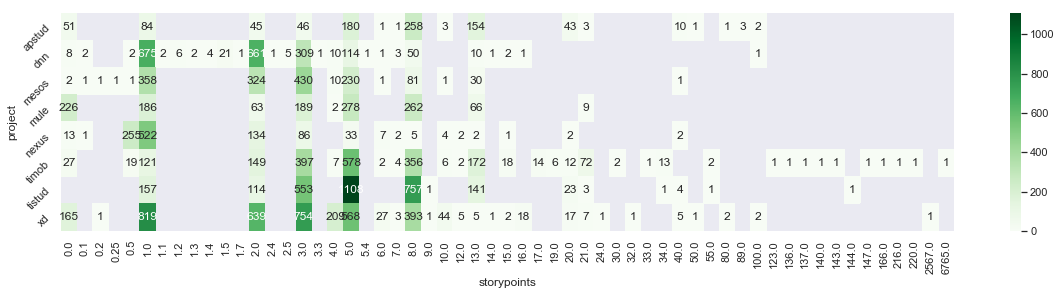

In [34]:
unique_keys = issues[['key', 'project', 'storypoints', 'fields.issuetype.name']].drop_duplicates()
proj_story_tab = pd.crosstab(unique_keys['project'], unique_keys['storypoints'], values = unique_keys['key'], aggfunc='count')
hm = sns.set(rc={'figure.figsize':(20,4)})
g = sns.heatmap(proj_story_tab, annot=True, cmap='Greens', fmt='g')
g.set_yticklabels(g.get_yticklabels(), rotation=45)

In [35]:
#field_in_issues, field_exclusion_filter, values_filter

story_points = ['0', '0.5', '1', '2', '3', '5', '8', '13', '20', '40', '100']
story_fields = ['Story Points', 'Actual Story Points']
field = 'StoryPoints'
e_low = ['0', '0.5', '1']
e_medium = ['2', '3']
e_high = ['5', '8', '13', '20', '40', '100']


estimates_df = categorical_metric(field,story_fields,'fields.issuetype.name','Epic',story_points,e_high,'estimation_high',e_medium,'estimation_medium',e_low,'estimation_low')
estimates_df_agg = categorical_metric_agg(estimates_df, '`'+field+'`','estimation_high', 'estimation_medium', 'estimation_low')

In [36]:
estimates_df.head()

,user,project,key,StoryPoints
0,adam-mesos,mesos,MESOS-1733,estimation_high
1,adam-mesos,mesos,MESOS-2043,estimation_high
2,adam-mesos,mesos,MESOS-2110,estimation_high
3,adam-mesos,mesos,MESOS-2222,estimation_medium
4,adam-mesos,mesos,MESOS-2315,estimation_medium


In [37]:
print(estimates_df.shape[0],estimates_df[['user', 'key']].drop_duplicates().shape[0])

6840 6840


In [38]:
print(estimates_df_agg.shape[0], 
      changelog[(changelog['field'].isin(story_fields)) & (changelog['author']=='grussell')]['key'].drop_duplicates().shape[0])

76 64


In [39]:
print(estimates_df_agg[(pd.isnull(estimates_df_agg['estimation_high'])==False)
                         & (pd.isnull(estimates_df_agg['estimation_medium'])==False)
                         & (pd.isnull(estimates_df_agg['estimation_low'])==False)].shape[0])

print(estimates_df_agg[(pd.isnull(estimates_df_agg['estimation_high'])==False)
                         | (pd.isnull(estimates_df_agg['estimation_medium'])==False)
                         | (pd.isnull(estimates_df_agg['estimation_low'])==False)].shape[0])

56
76


In [40]:
estimates_df.to_csv('input_data/estimates_df.csv')
states_df.to_csv('input_data/states_df.csv')
priorities_df.to_csv('input_data/priorities_df.csv')
valid_users_times.to_csv('input_data/valid_users_times.csv')